In [99]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from utils import utils
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


### Extract PRECT anomalies time series over Seattle Metro Area (TARGET)

In [100]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [101]:
imp.reload(utils)
imp.reload(filemethods)
imp.reload(data_generator)

# data = ClimateData(
#     config["databuilder"], 
#     expname = config["expname"],
#     seed=seed,
#     data_dir = config["data_dir"], 
#     figure_dir=config["figure_dir"],
#     target_only = True, 
#     fetch=False,
#     verbose=False
# )

<module 'databuilder.data_generator' from '/Users/C830793391/Documents/Research/E3SM/databuilder/data_generator.py'>

In [102]:
# d_train, d_val, d_test = data.fetch_data()

In [103]:
# d_train["x"][500:540]

In [104]:
# import pickle
# import gzip

# target_PRECT_savename1 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename1 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_train_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename1, "wb") as fp:
#     pickle.dump(d_train, fp)

# target_PRECT_savename2 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename2 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_val_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename2, "wb") as fp:
#     pickle.dump(d_val, fp)

# target_PRECT_savename3 = "/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# #target_PRECT_savename3 = "/Users/C830793391/BIG_DATA/E3SM_Data/presaved/exp006_d_test_SeattleRegional_PRECT_1850-2014.pkl"
# with gzip.open(target_PRECT_savename3, "wb") as fp:
#     pickle.dump(d_test, fp)

Process + Pickle Inputs and Targets

In [105]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config, MJO = True, ENSO = True, other = False)

In [106]:
# s_dict_train["y"][500:540]

In [107]:
s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_train.pkl'
# with gzip.open(s_dict_savename1, "wb") as fp:
#     pickle.dump(s_dict_train, fp)

s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_val.pkl'
# with gzip.open(s_dict_savename2, "wb") as fp:
#     pickle.dump(s_dict_val, fp)

s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
# with gzip.open(s_dict_savename3, "wb") as fp:
#     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

with gzip.open(s_dict_savename2, "rb") as obj2:
    val_dat = pickle.load(obj2)
obj2.close()

with gzip.open(s_dict_savename3, "rb") as obj3:
    test_dat = pickle.load(obj3)
obj3.close()

In [108]:
train_dat["y"][121:-32].shape

(60058,)

In [109]:
print(np.isnan(train_dat["x"][121:-32]).any())
print(np.isnan(val_dat["x"][121:-32]).any())
print(np.isnan(test_dat["x"][121:-32]).any())

print(np.isnan(train_dat["y"][121:-32]).any())
print(np.isnan(val_dat["y"][121:-32]).any())
print(np.isnan(test_dat["y"][121:-32]).any())

False
False
False
False
False
False


Retrieve Data: 


In [139]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_val.pkl", front_cutoff, back_cutoff)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


Model Setup

In [111]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

torch.backends.mps is available
tensor([1.], device='mps:0')


In [112]:
# Visualize the model
torchinfo.summary(
    model,
    [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model.to(device)
trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 3]                   [64, 4]                   62
├─Linear: 1-1                            [64, 3]                   [64, 6]                   24
├─Linear: 1-2                            [64, 6]                   [64, 4]                   28
Total params: 114
Trainable params: 109
Non-trainable params: 5
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Epoch   0/5000
  7.7s - loss: 4.45938 - val_loss: 4.47568
Epoch   1/5000
  7.6s - loss: 4.45900 - val_loss: 4.47535
Epoch   2/5000
  7.8s - loss: 4.45871 - val_loss: 4.47504
Epoch   3/5000
  7.9s - loss: 4.45845 - val_loss: 4.47475
Epoch   4/5000
  7.9s - loss: 4.45826 - val_loss: 4.47448
Epoch   5/5000
  8.0s - loss: 4.45799 - val_loss: 4.47423
Epoch   6/5000
  8.0s - loss: 4.45779 - val_loss: 4.47399


dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


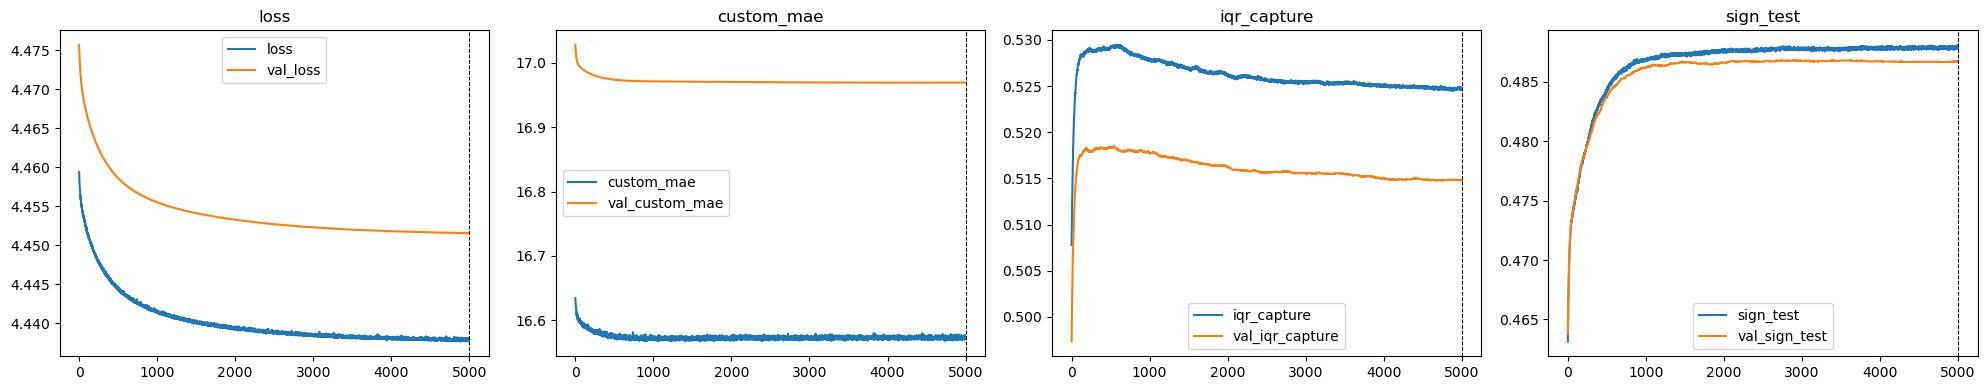

In [113]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

Plot Predictions Against Climatology: 

In [140]:
with torch.inference_mode():
    print(device)
    output = model.predict(dataset=testset, batch_size=128, device=device)
output[:20]

mps


array([[-11.036424  ,  18.59727   ,   0.42837867,   1.        ],
       [-10.941673  ,  18.302454  ,   0.42662042,   1.        ],
       [-10.970508  ,  18.51554   ,   0.41350764,   1.        ],
       [-11.290149  ,  19.185404  ,   0.4234501 ,   1.        ],
       [-11.242423  ,  19.180496  ,   0.42422152,   1.        ],
       [-11.022917  ,  18.983854  ,   0.42369202,   1.        ],
       [-10.949343  ,  18.664082  ,   0.4322624 ,   1.        ],
       [-10.5316925 ,  19.02323   ,   0.40717387,   1.        ],
       [-10.546996  ,  18.850258  ,   0.40697613,   1.        ],
       [-10.986475  ,  18.446253  ,   0.42741716,   1.        ],
       [-11.067108  ,  18.104347  ,   0.42768258,   1.        ],
       [-11.363358  ,  18.49823   ,   0.42204642,   1.        ],
       [-11.649129  ,  18.680906  ,   0.4315552 ,   1.        ],
       [-11.613235  ,  18.755842  ,   0.43930158,   1.        ],
       [-11.850762  ,  18.899195  ,   0.4368003 ,   1.        ],
       [-11.867398  ,  18

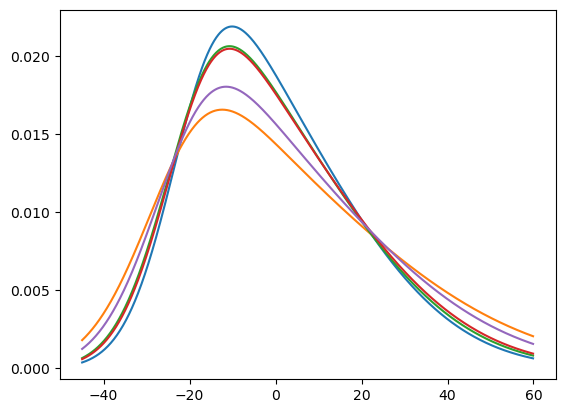

In [141]:
from shash.shash_torch import Shash
# params = np.zeros((2,4))
# # mu = 0; sigma=1., gamma=0, tau=1
# params[:,1] = 1.
# params[:,-1] = .003
# s = Shash(params)
s = Shash(output)

x = np.arange(-45,60,.1)
y = s.prob(x)
np.shape(y)

for i in (10, 200, 3000, 45, 599):
    plt.plot(x, y[:,i])

tensor([ 23.8183,   4.0516, -19.3651,  14.1594, -16.8442, -13.8512, -29.7419,
          1.2331,  -4.6666,  31.4550, -22.0554, -13.7370, -36.5322, -22.2667,
          0.0539,  -9.0219, -10.6978,   5.4811, -25.6548, -25.7031,   8.7884,
         42.5415,   4.3520,   1.8670, -19.9317,  14.2489,  -2.1027,  13.6034,
         -9.6955, -24.7171,   7.2812,  26.9618, -15.9385, -24.0525,  -4.0757,
        -16.4406,  -6.1886,  -7.4764, -22.7018, -15.1373,  39.6559,  -0.4675,
        -41.9963, -23.7184,   4.4296, -35.0950,  10.5485,   7.6907,  38.6411,
        -10.8257])


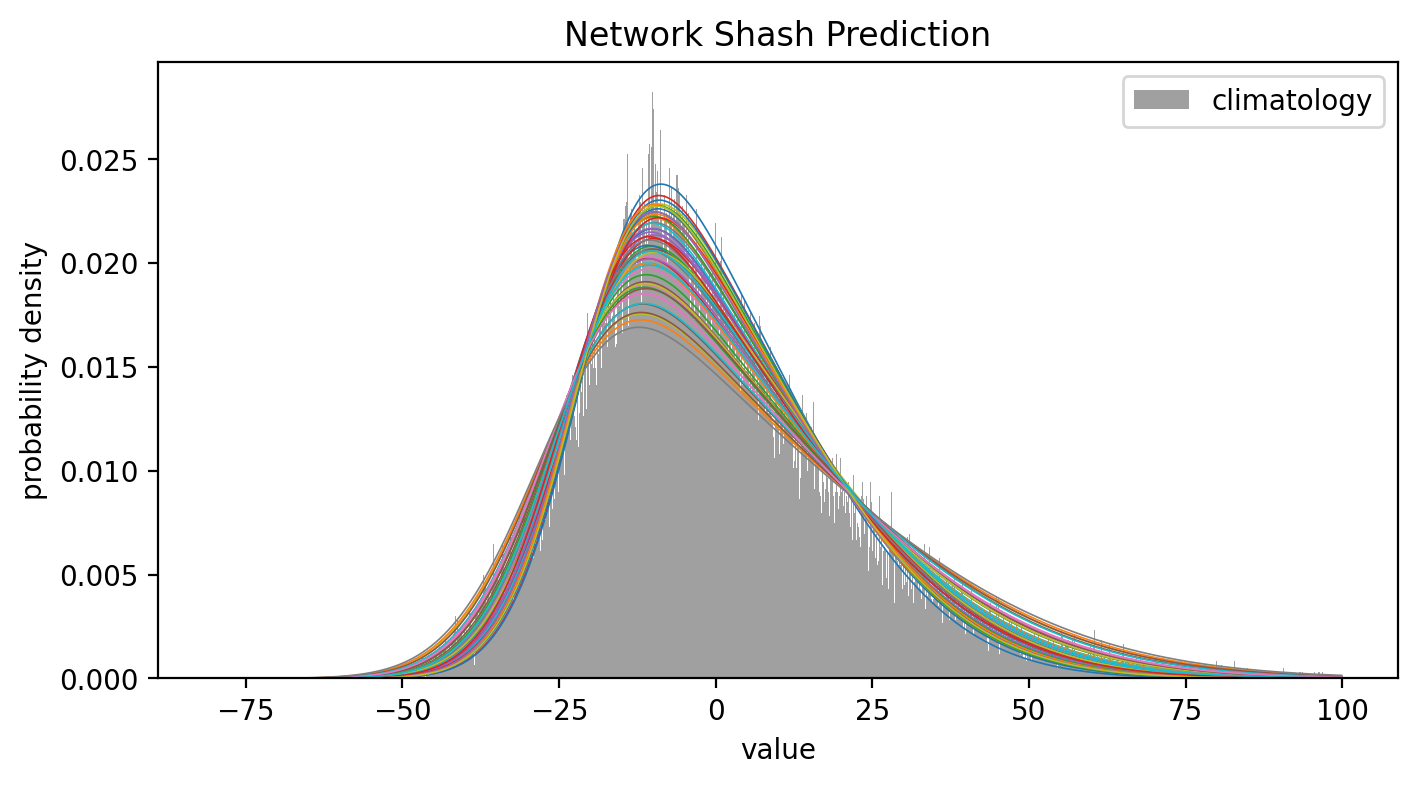

Maximum probability values for each sample: 0.023809535850102696


In [145]:
from databuilder.climatology import deriveclimatology

#samples = [18213, 290, 6090, 17, 1998]

samples = np.linspace(1, 59000, 50).astype(int)

x = np.arange(-80, 100, 0.1)

cfile = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

p = deriveclimatology(output, cfile, samples, x, valset)


In [117]:
valset.target[290]

-4.347527699960731

In [118]:
valset.target[18213]

-20.086445890272973

In [119]:
valset.target[1998]

23.622465554501524

In [120]:
valset.target[6090]

4.580923111565591

In [121]:
valset.target[17]

-5.682025498109971

In [122]:
valset.target[0]

21.29881632115139